In [2]:
using LinearAlgebra
using Plots
using Random

function check_diagonal_dominance(A::Matrix{Float64})
    n = size(A, 1)
    min_dominance = Inf
    is_dominant = true

    for i in 1:n
        diagonal_element = abs(A[i, i])
        row_sum = sum(abs(A[i, j]) for j in 1:n if j != i)
        dominance = diagonal_element - row_sum

        min_dominance = min(min_dominance, dominance)
        if dominance <= 0
            is_dominant = false
        end
    end

    if !is_dominant
        min_dominance = min(min_dominance, 0.0)
    end

    return is_dominant, min_dominance
end

check_diagonal_dominance (generic function with 1 method)

In [3]:
function gauss_solve_vector(A::Matrix{Float64}, b::Vector{Float64})
    n = length(b)
    
    M = copy(A)
    r = copy(b)

    for i in 1:n
        if M[i, i] == 0
            throw(ErrorException("Нулевой диагональный элемент в строке $i, метод без перестановок не применим."))
        end

        for k in (i+1):n
            if M[k, i] != 0
                factor = M[k, i] / M[i, i]
                for j in i:n
                    M[k, j] -= factor * M[i, j]
                end
                r[k] -= factor * r[i]
            end
        end
    end

    x = zeros(n)
    
    for i in n:-1:1
        x[i] = r[i]
        for k in (i+1):n
            x[i] -= M[i, k] * x[k]
        end
        if M[i, i] == 0
            throw(ErrorException("Матрица вырождена."))
        end
        x[i] /= M[i, i]
    end

    return x
end


gauss_solve_vector (generic function with 1 method)

In [4]:
function gauss_solve_vector_column_pivot(A::Matrix{Float64}, b::Vector{Float64})
    n = length(b)
    
    M = copy(A)
    r = copy(b)
    
    col_perm = collect(1:n)

    for i in 1:n
        max_col = i
        max_val = abs(M[i, i])
        
        for j in (i+1):n
            if abs(M[i, j]) > max_val
                max_val = abs(M[i, j])
                max_col = j
            end
        end
        
        if max_col != i
            for k in 1:n
                M[k, i], M[k, max_col] = M[k, max_col], M[k, i]
            end
            col_perm[i], col_perm[max_col] = col_perm[max_col], col_perm[i]
        end
        
        if abs(M[i, i]) < 1e-12
            throw(ErrorException("Матрица вырождена или близка к вырожденной."))
        end

        for k in (i+1):n
            if M[k, i] != 0
                factor = M[k, i] / M[i, i]
                for j in i:n
                    M[k, j] -= factor * M[i, j]
                end
                r[k] -= factor * r[i]
            end
        end
    end

    x_temp = zeros(n)
    
    for i in n:-1:1
        x_temp[i] = r[i]
        for k in (i+1):n
            x_temp[i] -= M[i, k] * x_temp[k]
        end
        x_temp[i] /= M[i, i]
    end

    x = zeros(n)
    for i in 1:n
        x[col_perm[i]] = x_temp[i]
    end

    return x
end

gauss_solve_vector_column_pivot (generic function with 1 method)

In [5]:

function gauss_solve_vector_row_pivot(A::Matrix{Float64}, b::Vector{Float64})
    n = length(b)
    
    M = copy(A)
    r = copy(b)

    for i in 1:n
        max_row = i
        max_val = abs(M[i, i])
        
        for k in (i+1):n
            if abs(M[k, i]) > max_val
                max_val = abs(M[k, i])
                max_row = k
            end
        end
        
        if max_row != i
            for j in 1:n
                M[i, j], M[max_row, j] = M[max_row, j], M[i, j]
            end
            r[i], r[max_row] = r[max_row], r[i]
        end
        
        if abs(M[i, i]) < 1e-12
            throw(ErrorException("Матрица вырождена или близка к вырожденной."))
        end

        for k in (i+1):n
            if M[k, i] != 0
                factor = M[k, i] / M[i, i]
                for j in i:n
                    M[k, j] -= factor * M[i, j]
                end
                r[k] -= factor * r[i]
            end
        end
    end

    x = zeros(n)
    
    for i in n:-1:1
        x[i] = r[i]
        for k in (i+1):n
            x[i] -= M[i, k] * x[k]
        end
        x[i] /= M[i, i]
    end

    return x
end

gauss_solve_vector_row_pivot (generic function with 1 method)

In [6]:
function gauss_solve_vector_combined(A::Matrix{Float64}, b::Vector{Float64})
    n = length(b)
    
    M = copy(A)
    r = copy(b)
    
    col_perm = collect(1:n)

    for i in 1:n
        max_row = i
        max_col = i
        max_val = abs(M[i, i])
        
        for k in i:n
            for j in i:n
                if abs(M[k, j]) > max_val
                    max_val = abs(M[k, j])
                    max_row = k
                    max_col = j
                end
            end
        end
        
        if max_row != i
            for j in 1:n
                M[i, j], M[max_row, j] = M[max_row, j], M[i, j]
            end
            r[i], r[max_row] = r[max_row], r[i]
        end
        
        if max_col != i
            for k in 1:n
                M[k, i], M[k, max_col] = M[k, max_col], M[k, i]
            end
            col_perm[i], col_perm[max_col] = col_perm[max_col], col_perm[i]
        end
        
        if abs(M[i, i]) < 1e-12
            throw(ErrorException("Матрица вырождена или близка к вырожденной."))
        end

        for k in (i+1):n
            if M[k, i] != 0
                factor = M[k, i] / M[i, i]
                for j in i:n
                    M[k, j] -= factor * M[i, j]
                end
                r[k] -= factor * r[i]
            end
        end
    end

    x_temp = zeros(n)
    
    for i in n:-1:1
        x_temp[i] = r[i]
        for k in (i+1):n
            x_temp[i] -= M[i, k] * x_temp[k]
        end
        x_temp[i] /= M[i, i]
    end

    x = zeros(n)
    for i in 1:n
        x[col_perm[i]] = x_temp[i]
    end

    return x
end

gauss_solve_vector_combined (generic function with 1 method)

Генерация случайной матрицы A и вектора x...

Матрица A (4×4):


4×4 Matrix{Float64}:
 3.78144  4.98659   3.33513  1.83076
 4.55779  0.397539  2.35406  0.63572
 4.63512  4.74567   2.52184  4.54378
 1.64791  2.3023    3.03132  2.07215


Истинное решение x (4×1):


4-element Vector{Float64}:
 9.377862826128212
 8.029377905414526
 3.923849063558956
 6.65034977695664


Вектор правой части b (4×1):


4-element Vector{Float64}:
 100.76282705471367
  59.39903972808405
 121.6853096594773
  59.614854900184945


Сравнительный анализ методов Гаусса:
────────────────────────────────────────────────────────────

Метод Гаусса (без выбора главного элемента):
  → Абсолютная ошибка решения: 5.329070518200751e-15
  → Относительная ошибка решения: 3.6596843596471456e-16
  → Оценка влияния округлений: 2.797489650821439e-14
  → Теоретическая граница возмущений: 2.3063022406216717e-11
  → Фактическое возмущение решения: 4.076554239379735e-12
  → Число обусловленности матрицы: 8.65207799721267

Метод Гаусса (с выбором по столбцам):
  → Абсолютная ошибка решения: 4.803559250984066e-15
  → Относительная ошибка решения: 3.298794902680345e-16
  → Оценка влияния округлений: 2.797489650821439e-14
  → Теоретическая граница возмущений: 3.007379421139852e-11
  → Фактическое возмущение решения: 9.456476763255404e-12
  → Число обусловленности матрицы: 8.65207799721267

Метод Гаусса (с выбором по строкам):
  → Абсолютная ошибка решения: 4.165926057296536e-15
  → Относительная ошибка решения: 2.8609068660780483e-16
  

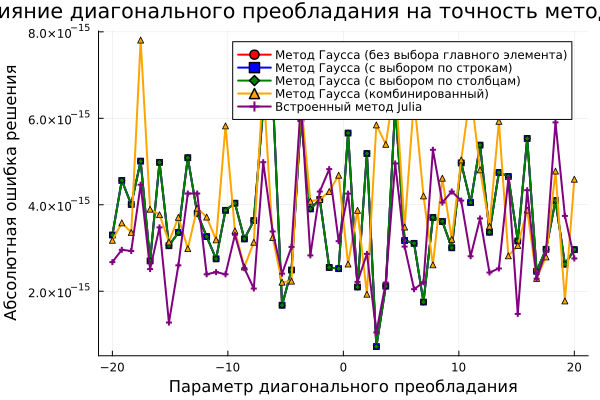

In [7]:
function compute_residual_errors(A::Matrix{Float64}, b::Vector{Float64}, x_approx::Vector{Float64})
    residual_vec = A * x_approx - b
    
    abs_residual = norm(residual_vec)
    
    b_norm = norm(b)
    rel_residual = b_norm == 0 ? abs_residual : abs_residual / b_norm
    
    return abs_residual, rel_residual
end

function estimate_rounding_error(A::Matrix{Float64}, b::Vector{Float64}, x_approx::Vector{Float64})
    residual_vec = A * x_approx - b
    
    try
        cond_number = cond(A)
        machine_eps = eps(Float64)
        round_error_est = cond_number * machine_eps * norm(x_approx)
        residual_norm = norm(residual_vec)
        
        return round_error_est, residual_norm
    catch
        return NaN, norm(residual_vec)
    end
end

function estimate_perturbation_error(A::Matrix{Float64}, b::Vector{Float64}, x_ref::Vector{Float64}, 
                                    deltaA::Matrix{Float64}, deltaB::Vector{Float64})
    try
        cond_number = cond(A)
        
        rel_deltaA = norm(deltaA) / norm(A)
        rel_deltaB = norm(deltaB) / norm(b)
        
        denominator = 1 - cond_number * rel_deltaA
        
        if denominator > 0
            theoretical_bound = cond_number * (rel_deltaA + rel_deltaB) / denominator
            
            A_mod = A + deltaA
            b_mod = b + deltaB
            
            x_mod = A_mod \ b_mod
            actual_perturb = norm(x_mod - x_ref) / norm(x_ref)
            
            return theoretical_bound, actual_perturb
        else
            return Inf, NaN
        end
    catch
        return NaN, NaN
    end
end

function full_error_report(A::Matrix{Float64}, b::Vector{Float64}, x_calc::Vector{Float64}, 
                           x_exact::Vector{Float64})
    diff = x_calc - x_exact
    abs_err = norm(diff)
    rel_err = abs_err / norm(x_exact)
    
    println("  → Абсолютная ошибка решения: ", abs_err)
    println("  → Относительная ошибка решения: ", rel_err)
    
    round_est, residual_norm = estimate_rounding_error(A, b, x_calc)
    println("  → Оценка влияния округлений: ", round_est)
    
    perturb_level = 1e-12
    deltaA = (rand(Float64, size(A)) .- 0.5) * 2 * perturb_level * norm(A)
    deltaB = (rand(Float64, size(b)) .- 0.5) * 2 * perturb_level * norm(b)
    
    theory_bound, actual_perturb = estimate_perturbation_error(A, b, x_calc, deltaA, deltaB)
    println("  → Теоретическая граница возмущений: ", theory_bound)
    println("  → Фактическое возмущение решения: ", actual_perturb)
    
    try
        cond_number = cond(A)
        println("  → Число обусловленности матрицы: ", cond_number)
    catch
        println("  → Число обусловленности: вычислить не удалось")
    end
    
    return abs_err, rel_err, round_est, residual_norm, theory_bound, actual_perturb
end

function make_dominant_matrix(n::Int, dominance::Float64, scale::Float64 = 10.0)
    A = rand(Float64, n, n) * scale
    
    for i in 1:n
        row_sum = sum(abs, A[i, :]) - abs(A[i, i])
        target_diag = row_sum + max(dominance, 1e-10)
        if target_diag > 0
            A[i, i] = sign(A[i, i]) * target_diag
        else
            A[i, i] = sign(A[i, i]) * (abs(A[i, i]) + 1.0)
        end
    end
    
    return A
end

make_random_vector(n::Int; scale=10.0) = rand(Float64, n) .* (2*scale) .- scale


function run_dominance_experiment(start_val, stop_val)
    n = 10
    num_points = 50
    
    dom_levels = range(start_val, stop_val, length=num_points)
    
    err_no_pivot = zeros(num_points)
    err_col_pivot = zeros(num_points)
    err_row_pivot = zeros(num_points)
    err_combined = zeros(num_points)
    err_builtin = zeros(num_points)
    
    for (idx, dom) in enumerate(dom_levels)
        A = make_dominant_matrix(n, dom, 10.0)
        x_exact = make_random_vector(n)
        b = A * x_exact
        
        _, actual_dom = check_diagonal_dominance(A)
        
        try
            x_no_pivot = gauss_solve_vector(A, b)
            err_no_pivot[idx] = norm(x_exact - x_no_pivot)
        catch
            err_no_pivot[idx] = NaN
        end
        
        try
            x_col_pivot = gauss_solve_vector_column_pivot(A, b)
            err_col_pivot[idx] = norm(x_exact - x_col_pivot)
        catch
            err_col_pivot[idx] = NaN
        end
        
        try
            x_row_pivot = gauss_solve_vector_row_pivot(A, b)
            err_row_pivot[idx] = norm(x_exact - x_row_pivot)
        catch
            err_row_pivot[idx] = NaN
        end
        
        try
            x_combined = gauss_solve_vector_combined(A, b)
            err_combined[idx] = norm(x_exact - x_combined)
        catch
            err_combined[idx] = NaN
        end
        
        try
            x_builtin = A \ b
            err_builtin[idx] = norm(x_exact - x_builtin)
        catch
            err_builtin[idx] = NaN
        end
    end
    
    p = plot(dom_levels, err_no_pivot, 
             label="Метод Гаусса (без выбора главного элемента)", linewidth=2, marker=:circle, markersize=3, color=:red)
    plot!(p, dom_levels, err_row_pivot, 
          label="Метод Гаусса (с выбором по строкам)", linewidth=2, marker=:square, markersize=3, color=:blue)
    plot!(p, dom_levels, err_col_pivot, 
          label="Метод Гаусса (с выбором по столбцам)", linewidth=2, marker=:diamond, markersize=3, color=:green)
    plot!(p, dom_levels, err_combined, 
          label="Метод Гаусса (комбинированный)", linewidth=2, marker=:utriangle, markersize=3, color=:orange)
    plot!(p, dom_levels, err_builtin, 
          label="Встроенный метод Julia", linewidth=2, marker=:cross, markersize=3, color=:purple)
    
    xlabel!("Параметр диагонального преобладания")
    ylabel!("Абсолютная ошибка решения")
    title!("Влияние диагонального преобладания на точность методов Гаусса")
    
    return p
end

function main() 
    n = 4 
    
    println("Генерация случайной матрицы A и вектора x...")
    A = rand(Float64, n, n) * 5.0
    x_exact = rand(Float64, n) * 10.0
    
    b = A * x_exact
    x_builtin = A \ b
    
    println("\nМатрица A ($(n)×$(n)):")
    display(A)
    println("\nИстинное решение x ($(n)×1):")
    display(x_exact)
    println("\nВектор правой части b ($(n)×1):")
    display(b)
    
    methods = [
        ("Метод Гаусса (без выбора главного элемента)", gauss_solve_vector),
        ("Метод Гаусса (с выбором по столбцам)", gauss_solve_vector_column_pivot),
        ("Метод Гаусса (с выбором по строкам)", gauss_solve_vector_row_pivot),
        ("Метод Гаусса (комбинированный)", gauss_solve_vector_combined)
    ]
    
    println("\nСравнительный анализ методов Гаусса:")
    println("─" ^ 60)
    
    for (method_name, method_func) in methods
        try
            println("\n$method_name:")
            x_calc = method_func(A, b)
            
            full_error_report(A, b, x_calc, x_exact)
            
        catch e
            println("  Ошибка: ", e)
        end
    end
    
    display(run_dominance_experiment(-20, 20))

end

main()
